In [ ]:
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import plotly.graph_objects as go
from plotly.offline import iplot
from scipy.stats import chi2_contingency


In [ ]:
file_pathgend = '/content/drive/MyDrive/gender_affirmation.xlsx'
data_gender = pd.read_excel(file_pathgend)


In [ ]:
data_gender

In [ ]:
data_gender.dtypes


In [ ]:
#number of Na in each col
for column in data_gender.columns:
    na_count = data_gender[column].isna().sum()
    print(f"{column}: {na_count} NaN values")

In [ ]:
data_gender.columns[data_gender.isna().all()].tolist()

[]

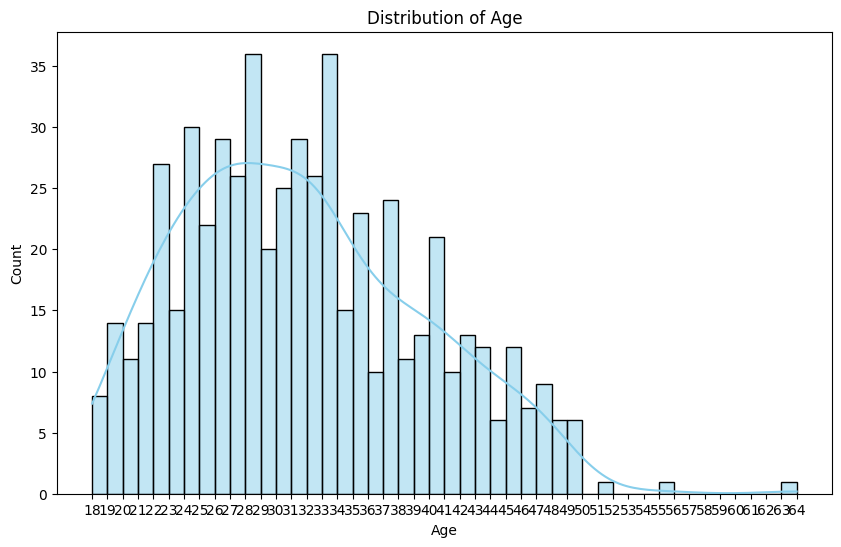

In [ ]:

plt.figure(figsize=(10, 6))

# Create a histogram with KDE
sns.histplot(data_gender['age_t0'], kde=True, bins=int(data_gender['age_t0'].max() - data_gender['age_t0'].min()), color='skyblue')

# Set the x-ticks to show every integer
plt.xticks(np.arange(data_gender['age_t0'].min(), data_gender['age_t0'].max()+1, 1))

plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()


In [ ]:

# Convert 0 and 1 to 'No' and 'Yes' for better visualization
data_gender['hormones_t0'] = data_gender['hormones_t0'].map({0: 'No', 1: 'Yes'})
data_gender['hormones_t2'] = data_gender['hormones_t2'].map({0: 'No', 1: 'Yes'})
data_gender['hormones_t3'] = data_gender['hormones_t3'].map({0: 'No', 1: 'Yes'})

# Fill NaN values in the 'hormones_t2' and 'hormones_t3' columns
data_gender['hormones_t2'].fillna('No data', inplace=True)
data_gender['hormones_t3'].fillna('No data', inplace=True)

# Create pivot tables to get the count of people for each hormone transition
pivot_df_0_to_2 = pd.pivot_table(data_gender, index='hormones_t0', columns='hormones_t2', aggfunc='size', fill_value=0)
pivot_df_2_to_3 = pd.pivot_table(data_gender, index='hormones_t2', columns='hormones_t3', aggfunc='size', fill_value=0)


In [ ]:
# Define the desired order
#column_order = ['Yes', 'No', 'No data']

# Reindex the pivot tables
#pivot_df_0_to_2 = pivot_df_0_to_2.reindex(column_order, axis=1)
#pivot_df_2_to_3 = pivot_df_2_to_3.reindex(column_order, axis=1)

# Create source, target, value, and color lists for our Sankey diagram
source = []
target = []
value = []
color_links = []

# Create custom colors for the nodes
color_node = ['#4B8BBE','#e34bca','#4B8BBE','#e34bca','#646464']

# Process transitions from t0 to t2
for i, hormones_t0 in enumerate(pivot_df_0_to_2.index):
    for j, hormones_t2 in enumerate(pivot_df_0_to_2.columns):
        count = pivot_df_0_to_2.loc[hormones_t0, hormones_t2]
        if count > 0:
            source.append(i)
            target.append(len(pivot_df_0_to_2.index) + j)
            value.append(count)
            color_links.append(color_node[i])  # define the link color based on the source node

# Process transitions from t2 to t3
for i, hormones_t2 in enumerate(pivot_df_2_to_3.index):
    for j, hormones_t3 in enumerate(pivot_df_2_to_3.columns):
        count = pivot_df_2_to_3.loc[hormones_t2, hormones_t3]
        if count > 0:
            source.append(len(pivot_df_0_to_2.index) + i)
            target.append(len(pivot_df_0_to_2.index) + len(pivot_df_2_to_3.index) + j)
            value.append(count)
            color_links.append(color_node[i])  # define the link color based on the source node

# Define node labels (hormone usage and their respective states)
labels = ['No', 'Yes'] + ['No', 'Yes', 'No data'] * 2

# Create the Sankey diagram object
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = color_node,
      hovertemplate = '%{label}<extra></extra>', # custom hover text
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color_links, # apply the color to the links
      hovertemplate = '%{value} people moved from %{source.label} to %{target.label}<extra></extra>', # custom hover text
  ))])

# Style the layout
fig.update_layout(
    title_text="Hormone Usage Transition from t0 to t2 to t3",
    font_size=15,
)

fig.show()


In [ ]:
fig.write_html('hormone_fig.html')

In [ ]:
data_gender.iloc[:,5:15]

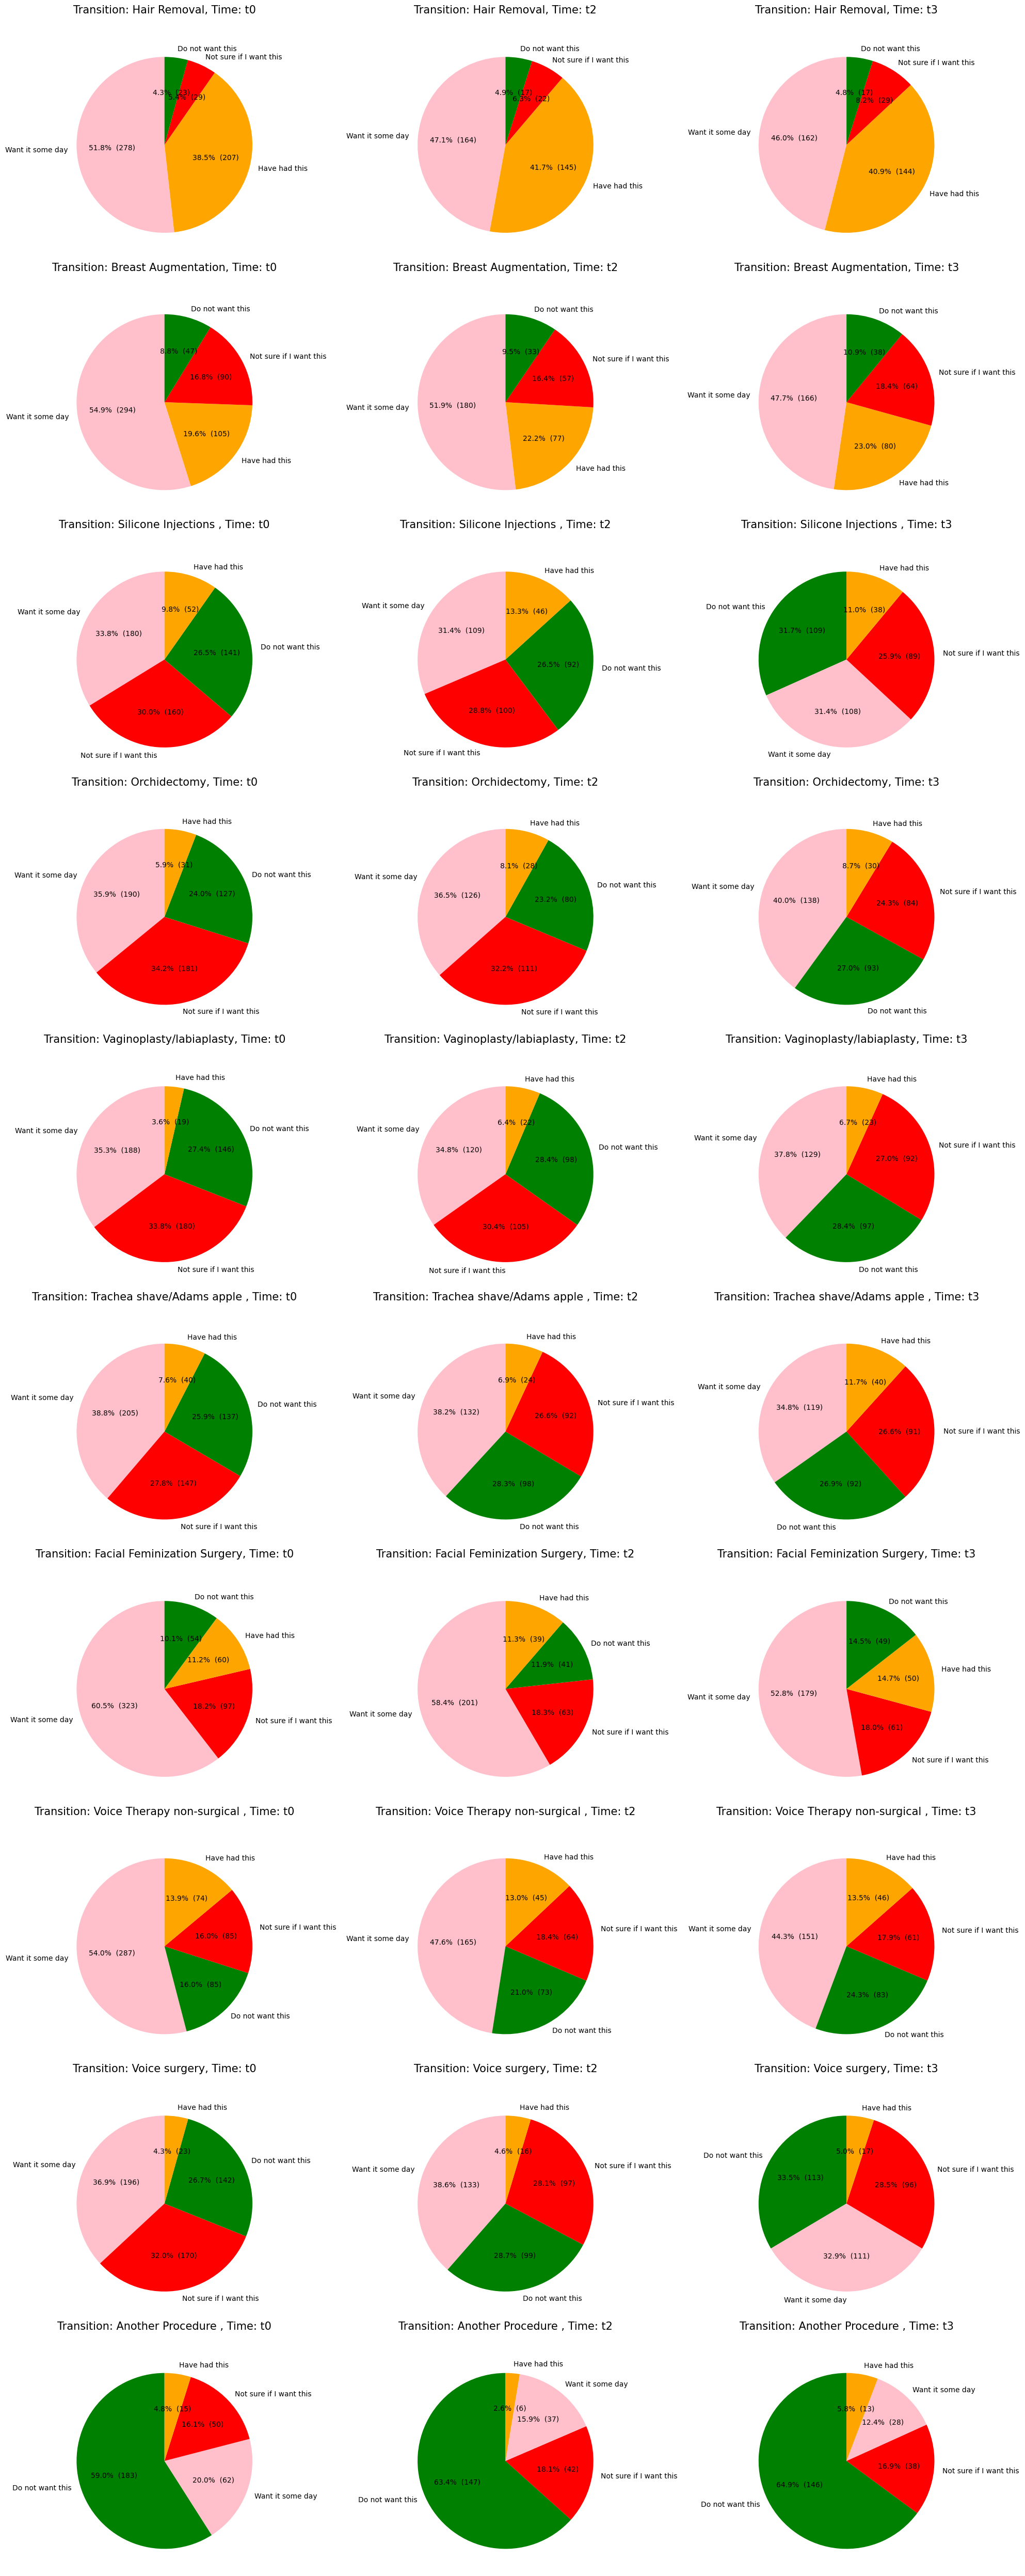

In [ ]:

transition_labels = {
    1: 'Hair Removal',
    2: 'Breast Augmentation',
    3: 'Silicone Injections ',
    4: 'Orchidectomy',
    5: 'Vaginoplasty/labiaplasty',
    6: 'Trachea shave/Adams apple ',
    7: 'Facial Feminization Surgery',
    8: 'Voice Therapy non-surgical ',
    9: 'Voice surgery',
    10: 'Another Procedure '
}
transition_options = {
    1: 'Have had this',
    2: 'Want it some day',
    3: 'Do not want this',
    4: 'Not sure if I want this'
}
num_labels = len(transition_labels)
num_times = 3

color_dict = {'Have had this': 'orange',
              'Want it some day': 'pink',
              'Do not want this': 'green',
              'Not sure if I want this': 'red',
              'No data': 'gray'}

fig, axs = plt.subplots(num_labels, num_times, figsize=(20, 50))
fig.subplots_adjust(hspace=0.2)
title_fontsize = 15  # Adjust the font size as per your preference
autopct_fontsize = 10


times = ['t0', 't2', 't3']

# create a function that formats the autopct label
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_format

for j, label in enumerate(transition_labels.values()):
    for i, t in enumerate(times):
        #transition_data = data_gender['transition_' + str(j+1) + '_' + t].dropna().value_counts(normalize=True)
        transition_data = data_gender['transition_' + str(j+1) + '_' + t].dropna().value_counts()

        labels = transition_data.index.tolist()
        values = transition_data.values

        # map labels to colors using color_dict
        colors = [color_dict[l] for l in labels]

        axs[j, i].pie(values, labels=labels, colors=colors, autopct=autopct_format(values), startangle=90, textprops={'fontsize': autopct_fontsize})
        axs[j, i].set_title('Transition: ' + label + ', Time: ' + t, pad=30, fontsize=title_fontsize)

plt.tight_layout()
plt.show()


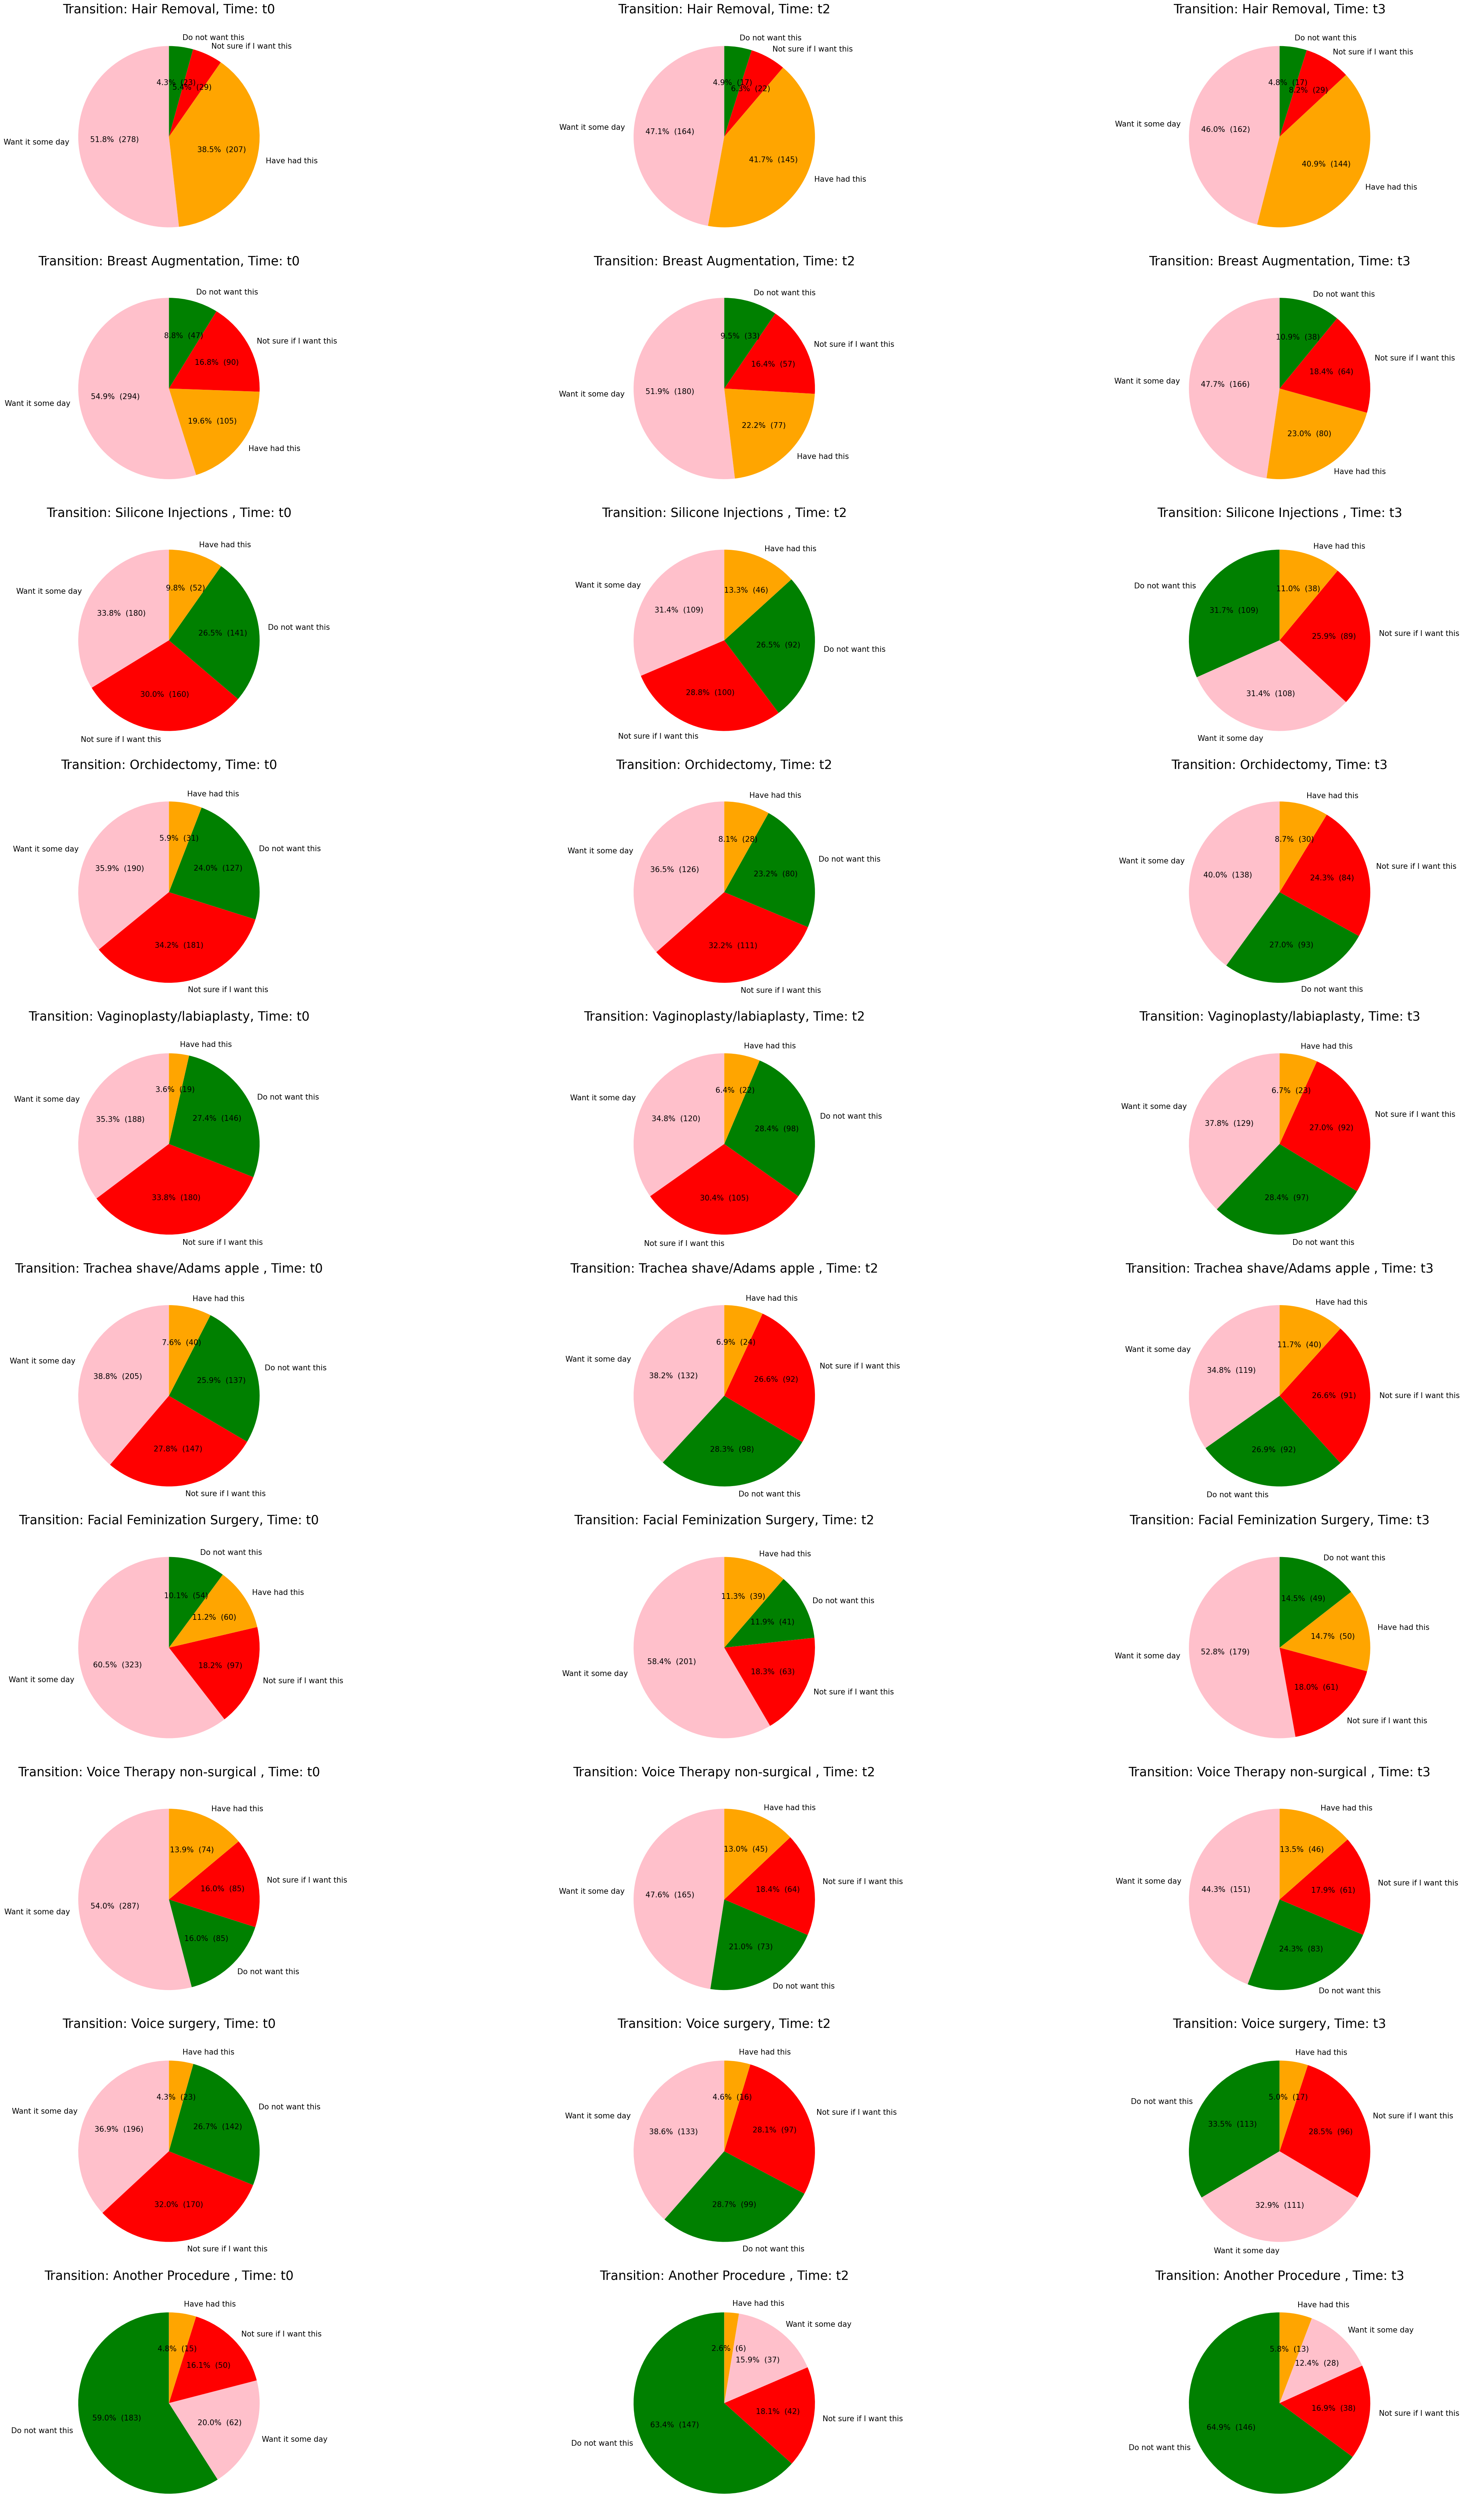

In [ ]:
transition_labels = {
    1: 'Hair Removal',
    2: 'Breast Augmentation',
    3: 'Silicone Injections ',
    4: 'Orchidectomy',
    5: 'Vaginoplasty/labiaplasty',
    6: 'Trachea shave/Adams apple ',
    7: 'Facial Feminization Surgery',
    8: 'Voice Therapy non-surgical ',
    9: 'Voice surgery',
    10: 'Another Procedure '
}

transition_options = {
    1: 'Have had this',
    2: 'Want it some day',
    3: 'Do not want this',
    4: 'Not sure if I want this'
}

num_labels = len(transition_labels)
num_times = 3

color_dict = {'Have had this': 'orange',
              'Want it some day': 'pink',
              'Do not want this': 'green',
              'Not sure if I want this': 'red',
              'No data': 'gray'}

fig, axs = plt.subplots(num_labels, num_times, figsize=(50, 70))
fig.subplots_adjust(hspace=0.2)
title_fontsize = 25  # Adjust the font size as per your preference
autopct_fontsize = 15  # Adjust autopct fontsize as per your preference


times = ['t0', 't2', 't3']

# create a function that formats the autopct label
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_format

for j, label in enumerate(transition_labels.values()):
    for i, t in enumerate(times):
        #transition_data = data_gender['transition_' + str(j+1) + '_' + t].dropna().value_counts(normalize=True)
        transition_data = data_gender['transition_' + str(j+1) + '_' + t].dropna().value_counts()

        labels = transition_data.index.tolist()
        values = transition_data.values

        # map labels to colors using color_dict
        colors = [color_dict[l] for l in labels]

        axs[j, i].pie(values, labels=labels, colors=colors, autopct=autopct_format(values), startangle=90, textprops={'fontsize': autopct_fontsize})
        axs[j, i].set_title('Transition: ' + label + ', Time: ' + t, pad=20, fontsize=title_fontsize)

plt.tight_layout()
plt.show()


In [ ]:
# List of column names you're interested in
transition_cols = [f'transition_{j+1}_{t}' for j in range(num_labels) for t in times]

# Drop the rows with missing values in the specified columns
data_gender.dropna(subset=transition_cols, inplace=True)


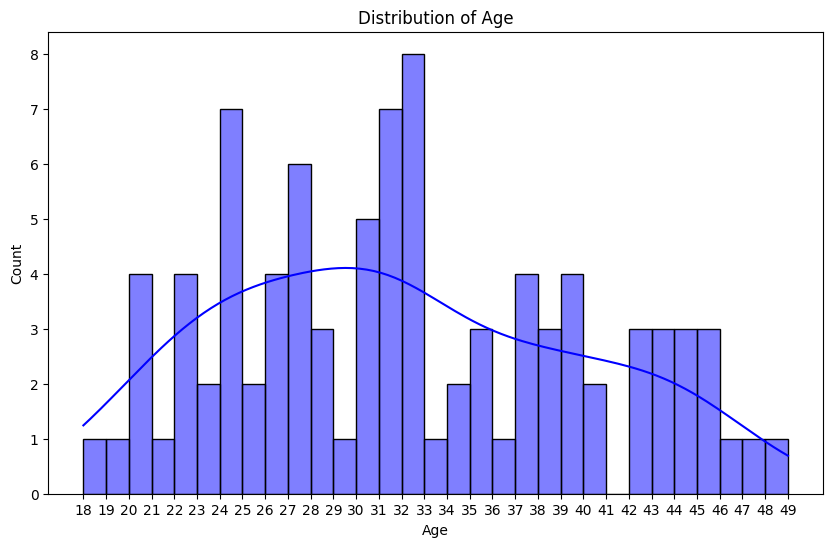

In [ ]:

plt.figure(figsize=(10, 6))

# Create a histogram with KDE
sns.histplot(data_gender['age_t0'], kde=True, bins=int(data_gender['age_t0'].max() - data_gender['age_t0'].min()), color='blue')

# Set the x-ticks to show every integer
plt.xticks(np.arange(data_gender['age_t0'].min(), data_gender['age_t0'].max()+1, 1))

plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()

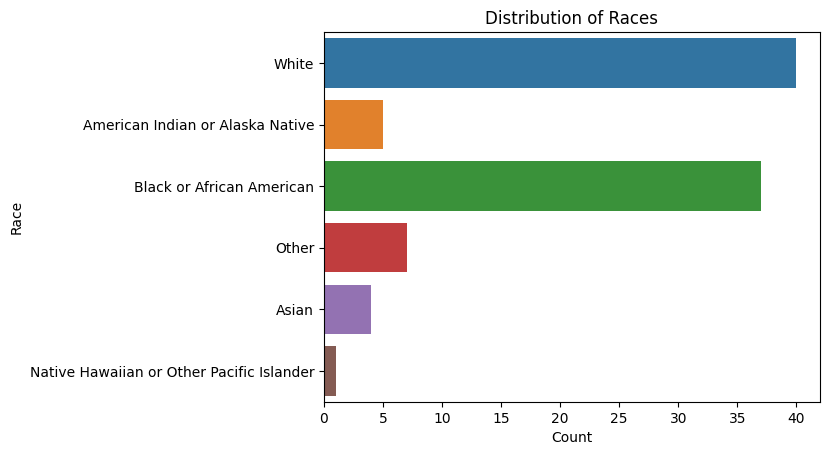

In [ ]:
df_exploded = data_gender.assign(race_t0=data_gender['race_t0'].str.split(',')).explode('race_t0')

# Plot the data
sns.countplot(y='race_t0', data=df_exploded)
plt.xlabel('Count')
plt.ylabel('Race')
plt.title('Distribution of Races')
plt.show()

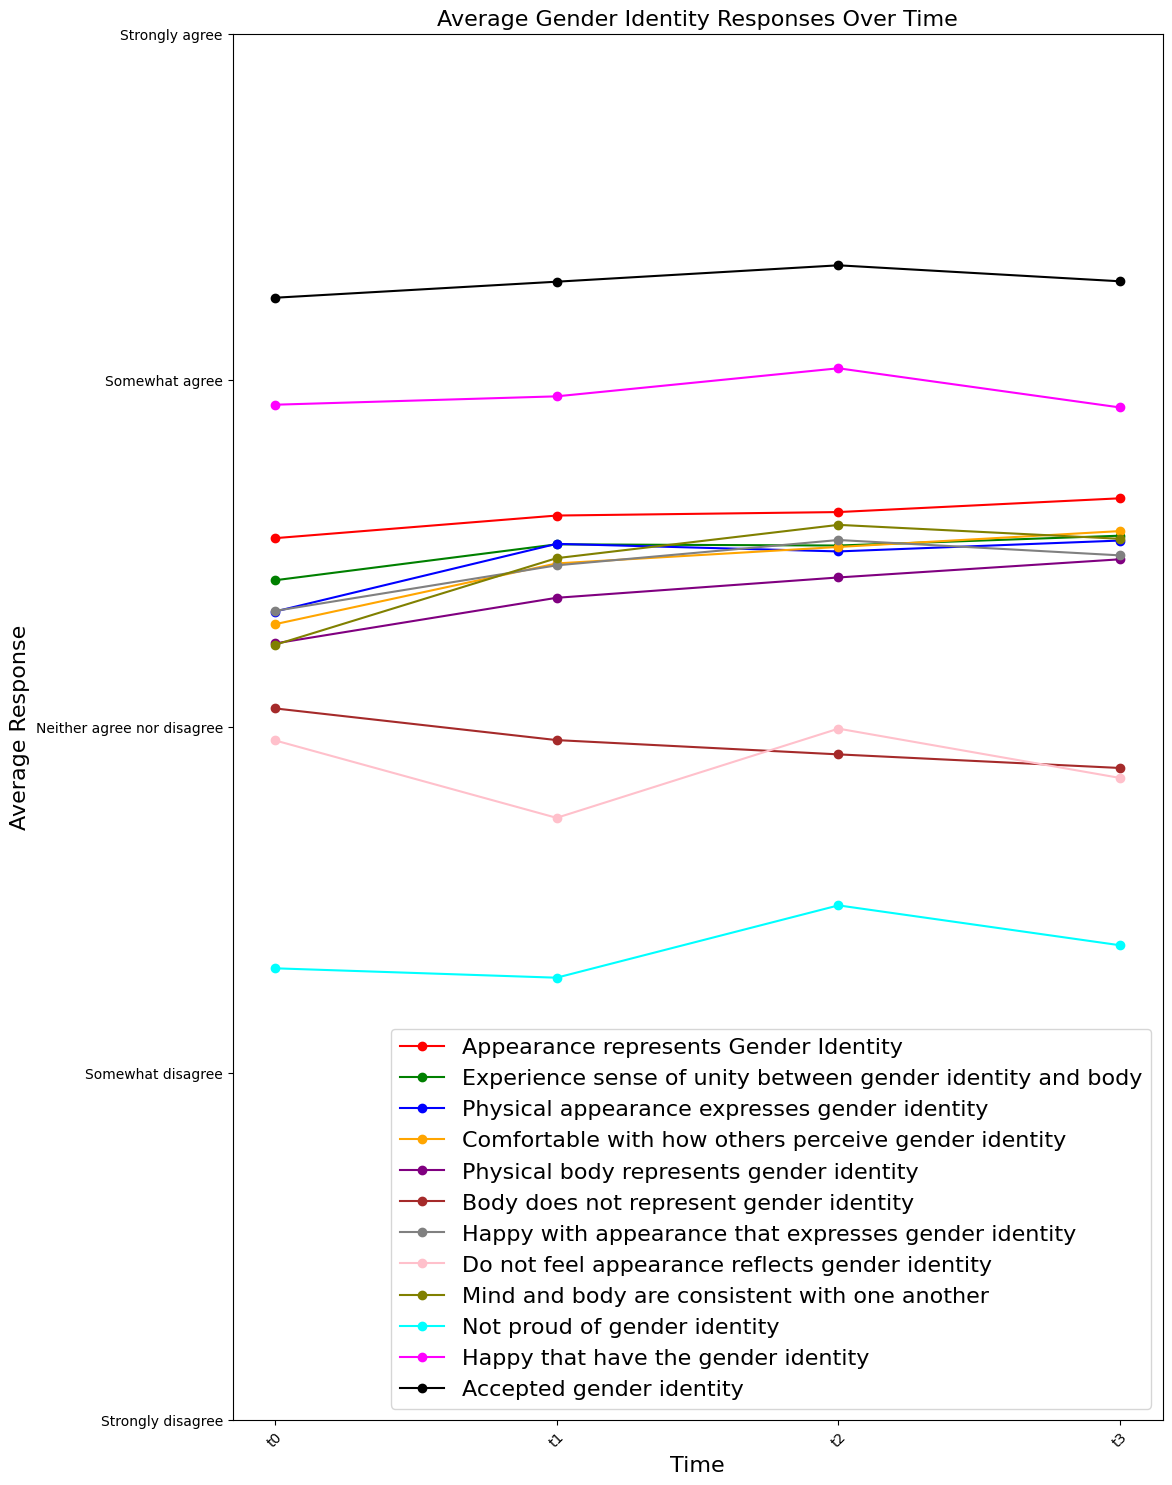

In [ ]:

gender_ident_labels = {
    1: 'Appearance represents Gender Identity',
    2: 'Experience sense of unity between gender identity and body',
    3: 'Physical appearance expresses gender identity',
    4: 'Comfortable with how others perceive gender identity',
    5: 'Physical body represents gender identity',
    6: 'Body does not represent gender identity',
    7: 'Happy with appearance that expresses gender identity',
    8: 'Do not feel appearance reflects gender identity',
    9: 'Mind and body are consistent with one another',
    10: 'Not proud of gender identity',
    11: 'Happy that have the gender identity',
    12: 'Accepted gender identity'
}
transition_options = {
    1: 'Strongly disagree',
    2: 'Somewhat disagree',
    3: 'Neither agree nor disagree',
    4: 'Somewhat agree',
    5: 'Strongly agree'
}
time_points = ['t0', 't1', 't2', 't3']
variable_names = ['tcs_' + str(i) + '_' for i in range(1, 13)]

# Calculate the average response for each variable at each time point
average_responses = {}
for name in variable_names:
    variable_responses = []
    for time_point in time_points:
        column_name = name + time_point
        average_response = data_gender[column_name].mean()
        variable_responses.append(average_response)
    average_responses[name] = variable_responses

# Define colors for the plot
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown',
          'gray', 'pink', 'olive', 'cyan', 'magenta', 'black']

# Plot the average response trends over time
plt.figure(figsize=(12, 18))
for i, name in enumerate(variable_names):
    label = gender_ident_labels[int(name[4:-1])]
    color = colors[i % len(colors)]  # Cycle through colors if more than 12 variables
    plt.plot(time_points, average_responses[name], marker='o', label=label, color=color)

plt.xlabel('Time', fontsize = 16)
plt.ylabel('Average Response', fontsize = 16)
plt.title('Average Gender Identity Responses Over Time', fontsize = 16)
plt.legend(loc='lower right', fontsize = 16)
plt.xticks(rotation=45)
plt.yticks(np.arange(1, 6), list(transition_options.values())),
font_size=30,
plt.show()


In [ ]:
gender_identity_names = {
    1.0: 'Strongly disagree',
    2.0: 'Somewhat disagree',
    3.0: 'Neither agree nor disagree',
    4.0: 'Somewhat agree',
    5.0: 'Strongly agree'
}

# Define the columns for gender identity and gender transition
gender_identity_columns = ['tcs_' + str(i) + '_t0' for i in range(1, 11)]
gender_transition_columns = ['transition_' + str(i) + '_t0' for i in range(1, 11)]

# Create a contingency table
contingency_table = pd.crosstab(data_gender[gender_identity_columns].values.flatten(),
                                data_gender[gender_transition_columns].values.flatten())

# Perform the chi-square test of independence
chi2, p, _, _ = chi2_contingency(contingency_table)

# Replace the numerical values in the contingency table with their corresponding names
contingency_table.index = contingency_table.index.map(gender_identity_names)

# Print the updated contingency table
print("Contingency Table:")
print(contingency_table)
print("\nChi-square test of independence:")
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")


Contingency Table:
col_0                       Do not want this  Have had this  \
row_0                                                         
Strongly disagree                        237             77   
Somewhat disagree                        173             77   
Neither agree nor disagree               171             81   
Somewhat agree                           260            176   
Strongly agree                           232            213   

col_0                       Not sure if I want this  Want it some day  
row_0                                                                  
Strongly disagree                               211               347  
Somewhat disagree                               209               381  
Neither agree nor disagree                      200               392  
Somewhat agree                                  340               582  
Strongly agree                                  214               478  

Chi-square test of independence:
C

the chi-square test of independence is performed to determine if there is a statistically significant association between gender identity and gender transition. The chi-square value is 95.45377228008336, indicating the magnitude of the association. The p-value is 4.305685807833209e-15, which is very small. This indicates strong evidence against the null hypothesis of independence and suggests that there is a significant relationship between gender identity and gender transition in the dataset.

There is a notable association between gender identity and gender transition, suggesting that these two variables are not independent of each other.

In [ ]:
# Define the column names for sexual orientation variables
sexual_orientation_columns = ['asexual_t0', 'bisexual_t0', 'gay_t0',
                              'heterosexual_t0', 'lesbian_t0', 'same_gender_loving_t0',
                              'pansexual_t0', 'queer_t0', 'sexo_other_t0']

# Count the frequency of each sexual orientation
orientation_counts = data_gender[sexual_orientation_columns].sum().sort_values(ascending=False)

# Print the top sexual orientations
print("Top Sexual Orientations:")
print(orientation_counts)

Top Sexual Orientations:
bisexual_t0              168
heterosexual_t0          147
pansexual_t0             109
gay_t0                    97
queer_t0                  75
sexo_other_t0             44
lesbian_t0                31
asexual_t0                21
same_gender_loving_t0     17
dtype: int64


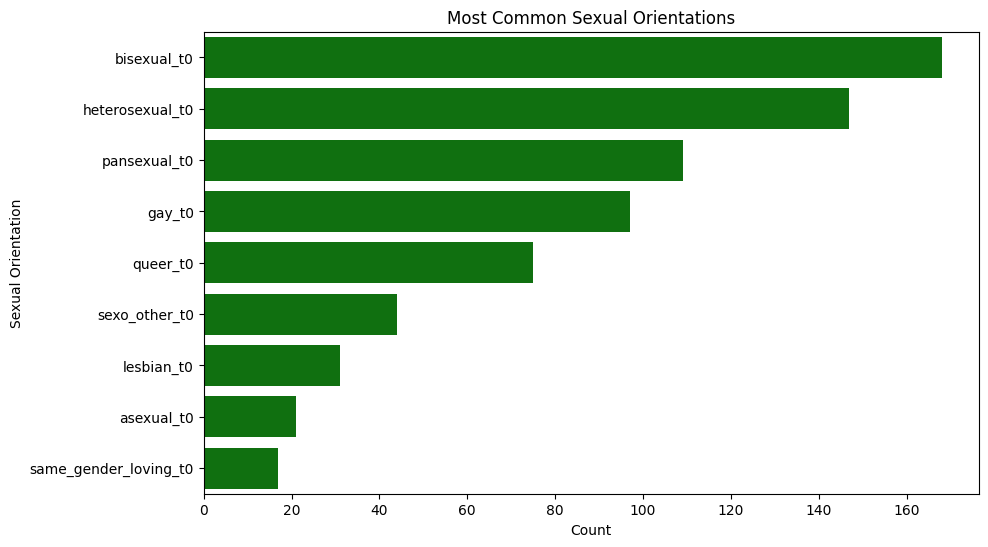

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=orientation_counts.values, y=orientation_counts.index, color='green')
plt.xlabel('Count')
plt.ylabel('Sexual Orientation')
plt.title('Most Common Sexual Orientations')
plt.show()
